<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/pi/lab10/PI_Lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Flickr8k image captioning dataset

*Image captioning* represents the task of describing the content of an image in natural language, i.e., generating captions for an image, thus its name. It is a fundamental problem in artificial intelligence that connects computer vision and natural language processing. It mimicks the remarkable human ability to compress huge amounts of visual infomation into descriptive language.

One of the most popular image captioning datasets is Flickr8k. In the following, we will take a look at this dataset.

First, we wil add the necessary imports.

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import spacy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import requests
import zipfile
import tarfile

We will also need the following functions from the previous laboratories:

In [ ]:
def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(url, folder=None):
    """Download and extract a zip file."""
    fname = download(url, cache_dir=".")
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    fp = zipfile.ZipFile(fname, 'r')
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

We can now download the images and the corresponding captions in the dataset.

In [ ]:
download_extract('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip', 'Flickr8k_Dataset')
download_extract('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip', 'Flickr8k_text')

'./Flickr8k_text'

In order to build a vocabulary for the dataset, we need a tokenizer for English words, which will be obtained from the `spacy` natural language processing library.

In [ ]:
spacy_en = spacy.load('en_core_web_sm')

Now, we can build the vocabulary, which will be done in the `Vocabulary` class. Notice the presence of the special tokens `<PAD>, <BOS>, <EOS>, <UNK>` which stand for padding, beginning of sequence, end of sequence, and unknown, respectively. The `build_vocabulary` function builds the vocabulary of the Flickr8k dataset using the above-defined tokenizer. The `numericalize` function transforms natural language text into its corresponding list of numerical indices.

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<BOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<BOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

The `load_captions` function adds all captions present in a given file to a list and returns it.

In [ ]:
def load_captions(path):
    captions_list = []
    image_captions = {}
    with open(path, "r") as file:
        for line in file.readlines():
            words = line.strip("\n").split()
            caption = ' '.join(words[1:])
            captions_list.append(caption)

    return captions_list

The above-defined function is now used to build the vocabulary from the `Flickr8k.token.txt` file, which contains all the captions in the dataset.

In [ ]:
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(load_captions("Flickr8k.token.txt"))

The Flick8k dataset has already defined the train, validation, and test splits, but the files `Flickr_8k.trainImages.txt`, `Flickr_8k.devImages.txt`, and `Flickr_8k.testImages.txt` only contain the filenames of the images in each split, but not the corresponding captions. In order to create files similar to `Flickr8k.token.txt`, where each filename has its corresponding captions, we use the `split_data` function, defined below.

In [ ]:
def split_data(all_captions_path, img_list_path, name):
    img_names = []
    with open(img_list_path, "r") as file:
        for line in file.readlines():
            img_name = line.strip("\n").split(".")[0]
            img_names.append(img_name)

    lines = []
    with open(all_captions_path, "r") as file:
        for line in file.readlines():
            words = line.replace(";",",").strip("\n").split()
            img_name = words[0].split(".")[0]

            if img_name in img_names:
                new_line = img_name + ".jpg;" + " ".join(words[1:])
                lines.append(new_line)

    with open(name, "w") as file:
        file.writelines("image;caption\n")
        lines = map(lambda x:x + '\n', lines)
        file.writelines(lines)

The `split_data` function is now used to create the three files containing the image filenames and their respective captions for all the three splits of the dataset: train, validation, and test.

In [ ]:
split_data("Flickr8k.token.txt", "Flickr_8k.trainImages.txt", "train.txt")
split_data("Flickr8k.token.txt", "Flickr_8k.devImages.txt", "validation.txt")
split_data("Flickr8k.token.txt", "Flickr_8k.testImages.txt", "test.txt")

We are now ready to build the `FlickrDataset` class. We will instantiate it for all of the three splits. However, the built vocabulary will be received as parameter for the class. The three files created above will be read using the `read_csv` function in the `pandas` library.

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, vocab, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file, sep=";")
        self.vocab = vocab
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<BOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

The `get_loader` function follows, which will allow us to create a dataset loader for each of the three splits. The `CollateDataset` class allows us to pad the captions to all have the same length, and also to have the sequence dimension first, followed by the batch dimension, which is needed in order to apply the `nn.LSTM` layer. This aspect is specified by the `batch_first` parameter of the `pad_sequence` function.

In [ ]:
class CollateDataset:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [ ]:
def get_loader(
    root_folder,
    annotation_file,
    vocab,
    transform,
    batch_size=32,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, vocab, transform=transform)

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=CollateDataset(pad_idx=dataset.vocab.stoi["<PAD>"]),
    )

    return loader, dataset

The `get_loader` function is now used to create the train, validation, and test loaders and datasets. The images are transformed to have the dimension $299\times 299$, since this is the required input dimension of the Inception-V3 CNN that will be used as the encoder.

In [ ]:
transform = transforms.Compose(
        [transforms.Resize((299, 299)),
         transforms.ToTensor(),
         transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
         ]
    )

train_loader, train_dataset = get_loader(
    "Flicker8k_Dataset", "train.txt", vocab, transform=transform
)

val_loader, val_dataset = get_loader(
    "Flicker8k_Dataset", "validation.txt", vocab, transform=transform
)

test_loader, test_dataset = get_loader(
    "Flicker8k_Dataset", "test.txt", vocab, transform=transform, shuffle=False
)

The shapes of the image and captions tensors can be verified:

In [ ]:
for idx, (imgs, captions) in enumerate(train_loader):
        print(imgs.shape)
        print(captions.shape)
        break

torch.Size([32, 3, 299, 299])
torch.Size([27, 32])


#Show and tell network

First, we design the encoder, which will be the Inception-V3 CNN pretrained on ImageNet. The last fully-connected layer will be replaced by a layer of size `embed_size`, the size of the embeddings, and `ReLU` nonlinearity and `Dropout` are added after it. This will be the only layer in the encoder that we train from scratch, the other part will be frozen.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)[0]
        return self.dropout(self.relu(features))

As for the decoder, it is represented by an `LSTM` with one or more hidden layers, followed by the prediction linear layer and `Dropout`. The `features` will represent the outputs of the encoder, that will be first passed through the `LSTM`, and afterwards the `LSTM` will process the embedded captions.

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        _, states = self.lstm(features.unsqueeze(0))
        hiddens, _ = self.lstm(embeddings, states)
        outputs = self.linear(hiddens)
        return outputs

The `CNNtoRNN` class connects the encoder and the decoder together. It also has a `caption_image` function which will be used to generate a caption in the inference phase.

In [ ]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=40):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(0)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

Putting it all together, we can define our model as being an instance of the `CNNtoRNN` class, defined above.

In [ ]:
embed_size = 256
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 1
device = try_gpu()
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

We initialize the optimizer and the loss.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])

It is important also to freeze the Inception-V3 CNN encoder, because it was pretrained on ImageNet. The only layer in the encoder that will not be frozen is the last fully-connected layer `fc` that was added by us.

In [ ]:
for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

We can now train the model. The model will be evaluated on the validation set after each epoch. We also add logging for the training loss after $100$ iterations.

In [ ]:
train_loss = [] #5 min
dev_loss = []

for epoch in range(num_epochs):
    model.train()

    train_run_loss = []
    dev_run_loss = []
    index = 0

    for idx, (imgs, captions) in enumerate(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, captions)
        loss = loss_criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        loss.backward()
        optimizer.step()
        train_run_loss.append(loss.item())
        if (index+1) % 100 == 0:
            print("[Train {}] Iteration {} | Running Loss: {}".format(epoch+1, index+1, round(np.mean(train_run_loss), 4)))
        index += 1

    avg_loss = np.mean(train_run_loss)
    train_loss.append(avg_loss)
    print("[Train] Epoch {} | Average Loss: {}".format(epoch+1, round(avg_loss, 4)))

    index = 0
    for idx, (imgs, captions) in enumerate(val_loader):
        with torch.no_grad():
            imgs = imgs.to(device)
            captions = captions.to(device)
            outputs = model(imgs, captions)
            loss = loss_criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            dev_run_loss.append(loss.item())
            index += 1

    avg_loss = np.mean(dev_run_loss)
    dev_loss.append(avg_loss)
    print("[Valid] Epoch {} | Average Loss: {}".format(epoch+1, round(avg_loss, 4)))

[Train 1] Iteration 100 | Running Loss: 8.0096
[Train 1] Iteration 200 | Running Loss: 8.0061
[Train 1] Iteration 300 | Running Loss: 8.0029
[Train 1] Iteration 400 | Running Loss: 7.9996
[Train 1] Iteration 500 | Running Loss: 7.996
[Train 1] Iteration 600 | Running Loss: 7.9927
[Train 1] Iteration 700 | Running Loss: 7.9893
[Train 1] Iteration 800 | Running Loss: 7.9859
[Train 1] Iteration 900 | Running Loss: 7.9825
[Train] Epoch 1 | Average Loss: 7.9813
[Valid] Epoch 1 | Average Loss: 7.9502


Finally, we can evaluate the trained model on an instance from the test set. In order to do this, the `print_example` function is used.

In [ ]:
def print_example(model, device, loader, dataset):
    model.eval()
    img, caption = next(iter(loader))
    caption = caption.transpose(0, 1)
    plt.imshow(img[0].permute(1, 2, 0))
    print("Example CORRECT: " + " ".join([dataset.vocab.itos[idx] for idx in caption[0].tolist()
      if dataset.vocab.itos[idx] not in {"<PAD>", "<BOS>", "<EOS>"}]))
    print(
        "Example OUTPUT: "
        + " ".join(model.caption_image(img[0].unsqueeze(0).to(device), dataset.vocab))
    )

Unfortunately, the results are not very good because we only trained our model for $1$ epoch.

Example CORRECT: a blond woman in a blue shirt appears to wait for a ride .
Example OUTPUT: looks slightly opening police posing scantily around hiker carry streets stares form column boarder skateboarders chased soaking dives suspended dives act as medium tow chair bent legs luggage roller teenager toddler bicycle defending dock training shallow swimmer dangling time bikini


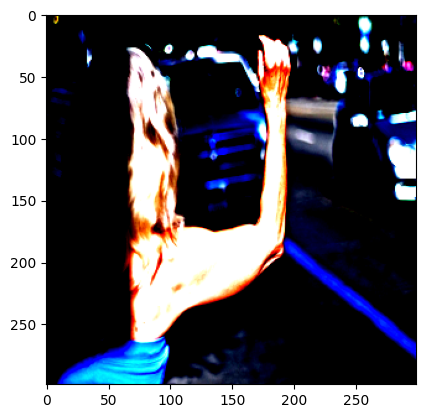

In [ ]:
print_example(model, device, test_loader, test_dataset)

#Exercises

1. Use a GRU with $2$ recurrent layers for the decoder part. Train the model for $1$ epoch and evaluate it on an instance from the test set.

1. Replace the LSTM layer in the decoder with two attention layers. Use any type of attention as long as it fits (for example, the second attention layer must be capable of mixing the embeddings with the state, while the first one only has to deal with one type of input). Train the model for $1$ epoch and evaluate it on an instance from the test set.